In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')

In [3]:
designated_ukc_cls = 3
num_classes = 2
embedding_size=64
bglog = BGLog(save_padded_num_sequences=False, debug=True,  load_from_pkl=True, )
train_test = bglog.get_tensor_train_val_test(ablation=5000, designated_ukc_cls=designated_ukc_cls )
train_data, val_data, test_data = train_test

ablation set to : 5000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
4049 data in class 2 not enough to split into train:4000 and validation:500, adding the entire data as ukc
class 3 is added as ukc
ukc_3:, 500
628 data in class 4 not enough to split into train:4000 and validation:500, adding the entire data as ukc
165 data in class 5 not enough to split into train:4000 and validation:500, adding the entire data as ukc
75 data in class 6 not enough to split into train:4000 and validation:500, adding the entire data as ukc
train: 0    4000
1    4000
Name: label, dtype: int64
val: 0    500
1    500
Name: label, dtype: int64
test: 0    500
1    500
3    500
Name: label, dtype: int64
[[1. 0.]
 [1. 0.]]
some example of labels:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[1. 0.]
 [1. 0.]]

In [4]:
line_encoder = LogLineEncoder(bglog, chars_in_line=64)
logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
hist = ptmodel.fit(train_data, validation_data=val_data, epochs=7) 

vocab_size: 50
Epoch 1/7
250/250 [==============================] - 24s 94ms/step - loss: 0.0247 - accuracy: 0.9887 - precision: 0.9887 - recall: 0.9887 - val_loss: 2.4964e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/7
250/250 [==============================] - 23s 93ms/step - loss: 1.1003e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.5709e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/7
250/250 [==============================] - 23s 93ms/step - loss: 2.9041e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6568e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/7
250/250 [==============================] - 23s 93ms/step - loss: 1.7834e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1410e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/7
250/250 [==============================] - 23s 

In [ ]:
# training and recalculating the centroids in each epoch

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.36it/s]


epoch: 1/50, train_loss: 4.657820701599121, eval_score: 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.46it/s]


epoch: 2/50, train_loss: 4.657818794250488, eval_score: 0.48433672811653994


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.49it/s]


epoch: 3/50, train_loss: 4.657764434814453, eval_score: 0.9543718455872323


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.47it/s]


epoch: 4/50, train_loss: 4.657783508300781, eval_score: 0.9543718455872323


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.13it/s]


epoch: 5/50, train_loss: 4.657760143280029, eval_score: 0.48433672811653994


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.46it/s]


epoch: 6/50, train_loss: 4.657793045043945, eval_score: 0.0


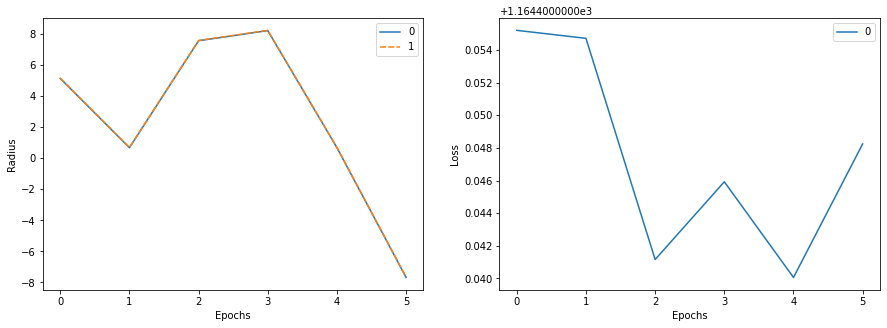

In [7]:
oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
_, _ = oset.train(train_data, epochs=50, lr_rate=3, wait_patient=3,)

In [ ]:
oset.plot_radius_chages()
preds = oset.openpredict(oset.features)
y_true, y_pred, _ = oset.evaluate(train_data)

ablation set to : 5000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
4049 data in class 2 not enough to split into train:4000 and validation:500, adding the entire data as ukc
class 3 is added as ukc
ukc_3:, 500
628 data in class 4 not enough to split into train:4000 and validation:500, adding the entire data as ukc
165 data in class 5 not enough to split into train:4000 and validation:500, adding the entire data as ukc
75 data in class 6 not enough to split into train:4000 and validation:500, adding the entire data as ukc
train: 0    4000
1    4000
Name: label, dtype: int64
val: 0    500
1    500
Name: label, dtype: int64
test: 0    500
1    500
3    500
Name: label, dtype: int64
[[1. 0.]
 [1. 0.]]
some example of labels:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[1. 0.]
 [1. 0.]]

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 1/50, train_loss: 9.517409324645996, eval_score: 0.4991861775385001


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.43it/s]


epoch: 2/50, train_loss: 9.517468452453613, eval_score: 0.4994994994994995


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 3/50, train_loss: 9.517437934875488, eval_score: 0.4994994994994995


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.32it/s]


epoch: 4/50, train_loss: 9.517426490783691, eval_score: 0.4994994994994995


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.26it/s]


epoch: 5/50, train_loss: 9.517449378967285, eval_score: 0.4994994994994995


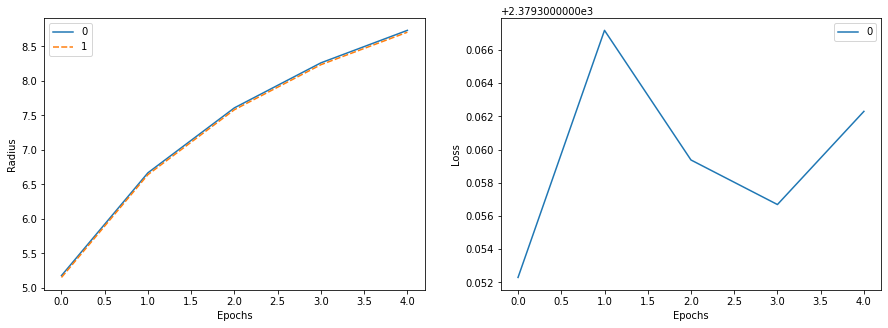

In [8]:
designated_ukc_cls = 3
num_classes = 2
embedding_size=8
lr_rate=3
bglog = BGLog(save_padded_num_sequences=False, debug=True,  load_from_pkl=True, )
train_test = bglog.get_tensor_train_val_test(ablation=5000, designated_ukc_cls=designated_ukc_cls )
train_data, val_data, test_data = train_test
line_encoder = LogLineEncoder(bglog, chars_in_line=64)
logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
hist = ptmodel.fit(train_data, validation_data=val_data, epochs=7)
oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
_, _ = oset.train(train_data, epochs=50, lr_rate=lr_rate, wait_patient=3,)


ablation set to : 5000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
4049 data in class 2 not enough to split into train:4000 and validation:500, adding the entire data as ukc
class 3 is added as ukc
ukc_3:, 500
628 data in class 4 not enough to split into train:4000 and validation:500, adding the entire data as ukc
165 data in class 5 not enough to split into train:4000 and validation:500, adding the entire data as ukc
75 data in class 6 not enough to split into train:4000 and validation:500, adding the entire data as ukc
train: 0    4000
1    4000
Name: label, dtype: int64
val: 0    500
1    500
Name: label, dtype: int64
test: 0    500
1    500
3    500
Name: label, dtype: int64
[[1. 0.]
 [1. 0.]]
some example of labels:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[1. 0.]
 [1. 0.]]

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.05it/s]


epoch: 1/50, train_loss: 4.325394153594971, eval_score: 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.03it/s]


epoch: 2/50, train_loss: 4.32535982131958, eval_score: 0.42404607631389485


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.02it/s]


epoch: 3/50, train_loss: 4.325413227081299, eval_score: 0.9544462629569013


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.03it/s]


epoch: 4/50, train_loss: 4.325409889221191, eval_score: 0.9544462629569013


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  6.98it/s]


epoch: 5/50, train_loss: 4.325465202331543, eval_score: 0.42404607631389485


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.26it/s]


epoch: 6/50, train_loss: 4.325425624847412, eval_score: 0.9548923412373945


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.34it/s]


epoch: 7/50, train_loss: 4.325436592102051, eval_score: 0.9549666167052732


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.36it/s]


epoch: 8/50, train_loss: 4.325387001037598, eval_score: 0.9550408719346049


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.26it/s]


epoch: 9/50, train_loss: 4.325341701507568, eval_score: 0.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.21it/s]


epoch: 10/50, train_loss: 4.325474739074707, eval_score: 0.42404607631389485


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.29it/s]


epoch: 11/50, train_loss: 4.3255085945129395, eval_score: 0.42404607631389485


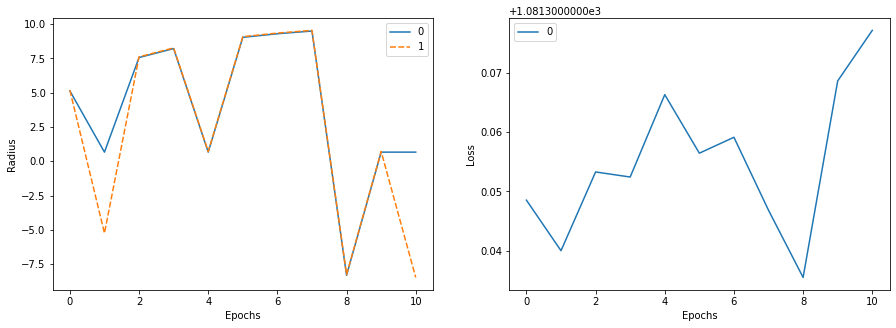

In [9]:
designated_ukc_cls = 3
num_classes = 2
embedding_size=128
lr_rate=3
optimizer='adam'
bglog = BGLog(save_padded_num_sequences=False, debug=True,  load_from_pkl=True, )
train_test = bglog.get_tensor_train_val_test(ablation=5000, designated_ukc_cls=designated_ukc_cls )
train_data, val_data, test_data = train_test
line_encoder = LogLineEncoder(bglog, chars_in_line=64)
logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
hist = ptmodel.fit(train_data, validation_data=val_data, epochs=7)
oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
_, _ = oset.train(train_data, epochs=50, lr_rate=lr_rate, wait_patient=3, optimizer=optimizer)

ablation set to : 5000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
4049 data in class 2 not enough to split into train:4000 and validation:500, adding the entire data as ukc
class 3 is added as ukc
ukc_3:, 500
628 data in class 4 not enough to split into train:4000 and validation:500, adding the entire data as ukc
165 data in class 5 not enough to split into train:4000 and validation:500, adding the entire data as ukc
75 data in class 6 not enough to split into train:4000 and validation:500, adding the entire data as ukc
train: 0    4000
1    4000
Name: label, dtype: int64
val: 0    500
1    500
Name: label, dtype: int64
test: 0    500
1    500
3    500
Name: label, dtype: int64
[[1. 0.]
 [1. 0.]]
some example of labels:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]]
[[1. 0.]
 [1. 0.]]

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.64it/s]


epoch: 1/50, train_loss: 4.294132232666016, eval_score: 0.4445987225770619


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.63it/s]


epoch: 2/50, train_loss: 4.294111728668213, eval_score: 0.4474374913662108


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.65it/s]


epoch: 3/50, train_loss: 4.294133186340332, eval_score: 0.4474374913662108


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.56it/s]


epoch: 4/50, train_loss: 4.294143199920654, eval_score: 0.4490358126721763


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 5/50, train_loss: 4.294092178344727, eval_score: 0.4479712945073144


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.68it/s]


epoch: 6/50, train_loss: 4.2941060066223145, eval_score: 0.4453688297282308


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.53it/s]


epoch: 7/50, train_loss: 4.294089317321777, eval_score: 0.4501718213058419


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.61it/s]


epoch: 8/50, train_loss: 4.294166088104248, eval_score: 0.4490358126721763


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.63it/s]


epoch: 9/50, train_loss: 4.2940897941589355, eval_score: 0.4490358126721763


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.58it/s]


epoch: 10/50, train_loss: 4.294095993041992, eval_score: 0.4507757792118633


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.62it/s]


epoch: 11/50, train_loss: 4.294108867645264, eval_score: 0.4453688297282308


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.62it/s]


epoch: 12/50, train_loss: 4.2940993309021, eval_score: 0.4501718213058419


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:32<00:00,  7.59it/s]


epoch: 13/50, train_loss: 4.294157028198242, eval_score: 0.4490358126721763


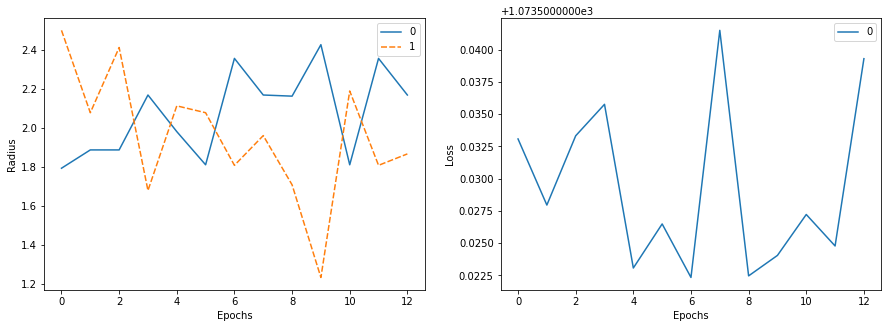

In [3]:
ablation=5000
designated_ukc_cls = 3
num_classes = 2
embedding_size=128
lr_rate=3
optimizer='sgd'
pretrain_epochs=3
octrain_epochs=50
wait_patient=3
bglog = BGLog(save_padded_num_sequences=False, debug=True,  load_from_pkl=True, )
train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
train_data, val_data, test_data = train_test
line_encoder = LogLineEncoder(bglog, chars_in_line=64)
logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)
oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
_, _ = oset.train(train_data, epochs=octrain_epochs, lr_rate=lr_rate, wait_patient=wait_patient, optimizer=optimizer)

In [12]:
ablation=5000
designated_ukc_cls = 3
num_classes = 2
embedding_size=128
lr_rate=3
optimizer='sgd'
pretrain_epochs=3
octrain_epochs=50
wait_patient=3
def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=50,wait_patient=3):
    bglog = BGLog(save_padded_num_sequences=False, debug=True,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, lr_rate=lr_rate, wait_patient=wait_patient, optimizer=optimizer)
    y_true, y_pred, _ = oset.evaluate(test_data)
    return test_data, oset

ablation set to : 4000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 3200
val_0:, 400
test_0:, 400
train_1:, 3200
val_1:, 400
test_1:, 400
train_2:, 3200
val_2:, 400
test_2:, 400
902 data in class 3 not enough to split into train:3200 and validation:400, adding the entire data as ukc
class 4 is added as ukc
ukc_4:, 400
165 data in class 5 not enough to split into train:3200 and validation:400, adding the entire data as ukc
75 data in class 6 not enough to split into train:3200 and validation:400, adding the entire data as ukc
train: 0    3200
1    3200
2    3200
Name: label, dtype: int64
val: 0    400
1    400
2    400
Name: label, dtype: int64
test: 0    400
1    400
2    400
4    400
Name: label, dtype: int64
[[1. 0. 0.]
 [1. 0. 0.]]
some example of labels:
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]]
<BatchDataset elemen

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.09it/s]


epoch: 1/50, train_loss: 2.9195125102996826, eval_score: 0.916983161300851


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.31it/s]


epoch: 2/50, train_loss: 2.9194819927215576, eval_score: 0.9372673321730682


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.32it/s]


epoch: 3/50, train_loss: 2.919602394104004, eval_score: 0.9561972113145142


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.30it/s]


epoch: 4/50, train_loss: 2.919618844985962, eval_score: 0.9609751278432501


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.12it/s]


epoch: 5/50, train_loss: 2.9196839332580566, eval_score: 0.9622346548544886


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.15it/s]


epoch: 6/50, train_loss: 2.919703960418701, eval_score: 0.9625951087747892


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.39it/s]


epoch: 7/50, train_loss: 2.919555902481079, eval_score: 0.962659108834949


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.39it/s]


epoch: 8/50, train_loss: 2.9195609092712402, eval_score: 0.9627755217704128


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.40it/s]


epoch: 9/50, train_loss: 2.9196717739105225, eval_score: 0.9629963897610967


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.40it/s]


epoch: 10/50, train_loss: 2.919571876525879, eval_score: 0.9632058343112863


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.38it/s]


epoch: 11/50, train_loss: 2.9196853637695312, eval_score: 0.9632581544520142


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.35it/s]


epoch: 12/50, train_loss: 2.9195938110351562, eval_score: 0.9632581544520142


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.36it/s]


epoch: 13/50, train_loss: 2.919670343399048, eval_score: 0.9633220880531336


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.30it/s]


epoch: 14/50, train_loss: 2.9195263385772705, eval_score: 0.9633220880531336


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.39it/s]


epoch: 15/50, train_loss: 2.9196012020111084, eval_score: 0.9633220880531336


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.39it/s]


epoch: 16/50, train_loss: 2.919496536254883, eval_score: 0.9633220880531336


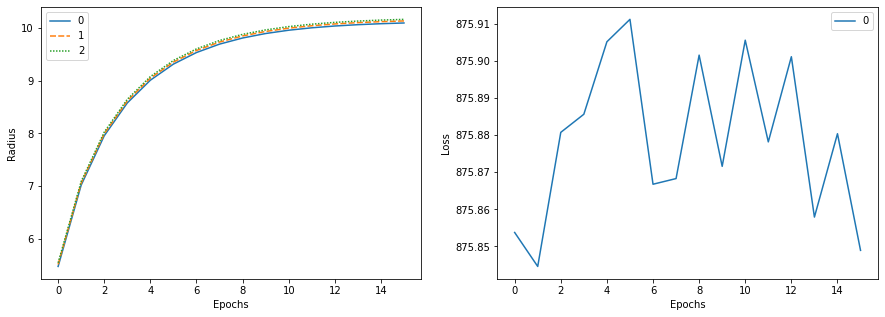

In [7]:
_, oset = oset_train(ablation=4000,designated_ukc_cls=4,num_classes=3,embedding_size=128,lr_rate=3,optimizer='adam',
pretrain_epochs=3,octrain_epochs=50,wait_patient=3)

In [8]:
y_true, y_pred, _ = oset.evaluate(test_data)

[[473   0   0   0  16]
 [  0 491   0   0   0]
 [  0   0   0   0   0]
 [  0   1 461   0  30]
 [  0   0   0   0   0]]
65.49
f1_weighted: 0.6598963671969721, f1_macro: 0.3964701378740036, f1_micro: 0.654891304347826, f_measure: {'Known': 49.5588, 'Open': 0, 'F1-score': 39.647}
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       489
           1       1.00      1.00      1.00       491
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00       492
         999       0.00      0.00      0.00         0

    accuracy                           0.65      1472
   macro avg       0.40      0.39      0.40      1472
weighted avg       0.67      0.65      0.66      1472



ablation set to : 4000
padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 3200
val_0:, 400
test_0:, 400
train_1:, 3200
val_1:, 400
test_1:, 400
train_2:, 3200
val_2:, 400
test_2:, 400
902 data in class 3 not enough to split into train:3200 and validation:400, adding the entire data as ukc
class 4 is added as ukc
ukc_4:, 400
165 data in class 5 not enough to split into train:3200 and validation:400, adding the entire data as ukc
75 data in class 6 not enough to split into train:3200 and validation:400, adding the entire data as ukc
train: 0    3200
1    3200
2    3200
Name: label, dtype: int64
val: 0    400
1    400
2    400
Name: label, dtype: int64
test: 0    400
1    400
2    400
4    400
Name: label, dtype: int64
[[1. 0. 0.]
 [1. 0. 0.]]
some example of labels:
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]]
<BatchDataset elemen

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.33it/s]


epoch: 1/50, train_loss: 10.224749565124512, eval_score: 0.3731431355008175


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.33it/s]


epoch: 2/50, train_loss: 10.224747657775879, eval_score: 0.5972276567664


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.34it/s]


epoch: 3/50, train_loss: 10.224748611450195, eval_score: 0.6072109375683045


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.19it/s]


epoch: 4/50, train_loss: 10.224749565124512, eval_score: 0.6118481331323827


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.19it/s]


epoch: 5/50, train_loss: 10.224740982055664, eval_score: 0.6152558237594302


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:43<00:00,  6.96it/s]


epoch: 6/50, train_loss: 10.224753379821777, eval_score: 0.6171480612395411


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.22it/s]


epoch: 7/50, train_loss: 10.224750518798828, eval_score: 0.62083856077182


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.07it/s]


epoch: 8/50, train_loss: 10.224750518798828, eval_score: 0.6222789774741402


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.19it/s]


epoch: 9/50, train_loss: 10.224750518798828, eval_score: 0.623550084849001


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.14it/s]


epoch: 10/50, train_loss: 10.224748611450195, eval_score: 0.6244470538087855


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.23it/s]


epoch: 11/50, train_loss: 10.224746704101562, eval_score: 0.6250257225370702


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.21it/s]


epoch: 12/50, train_loss: 10.224747657775879, eval_score: 0.6255506441976384


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.23it/s]


epoch: 13/50, train_loss: 10.224745750427246, eval_score: 0.6257471105416951


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.31it/s]


epoch: 14/50, train_loss: 10.224750518798828, eval_score: 0.6260478634681328


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.35it/s]


epoch: 15/50, train_loss: 10.224745750427246, eval_score: 0.6261785889586557


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:43<00:00,  6.88it/s]


epoch: 16/50, train_loss: 10.224747657775879, eval_score: 0.6263614449248872


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.34it/s]


epoch: 17/50, train_loss: 10.224752426147461, eval_score: 0.626426727654802


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.26it/s]


epoch: 18/50, train_loss: 10.224750518798828, eval_score: 0.6264919875506036


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.29it/s]


epoch: 19/50, train_loss: 10.224753379821777, eval_score: 0.6264919875506036


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.31it/s]


epoch: 20/50, train_loss: 10.224748611450195, eval_score: 0.6264919875506036


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.30it/s]


epoch: 21/50, train_loss: 10.224750518798828, eval_score: 0.6264919875506036


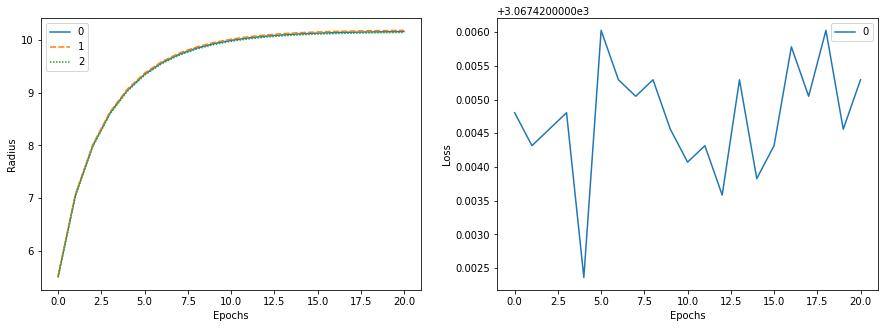

[[395   0   0   0   5]
 [  0   0   0   0 400]
 [  0   0 316   0  84]
 [  0   0 250   0 150]
 [  0   0   0   0   0]]
44.44
f1_weighted: 0.4119887495605298, f1_macro: 0.32959099964842375, f1_micro: 0.444375, f_measure: {'Known': 41.1989, 'Open': 0, 'F1-score': 32.9591}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.00      0.00      0.00       400
           2       0.56      0.79      0.65       400
           4       0.00      0.00      0.00       400
         999       0.00      0.00      0.00         0

    accuracy                           0.44      1600
   macro avg       0.31      0.36      0.33      1600
weighted avg       0.39      0.44      0.41      1600



In [11]:
test_data, oset = oset_train(ablation=4000,designated_ukc_cls=4,num_classes=3,embedding_size=256,lr_rate=3,optimizer='adam',
pretrain_epochs=3,octrain_epochs=50,wait_patient=3)

In [ ]:
test_data, oset = oset_train(ablation=4000,designated_ukc_cls=4,num_classes=3,embedding_size=256,lr_rate=5,optimizer='adam',
pretrain_epochs=3,octrain_epochs=50,wait_patient=3)